In [1]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pyedflib
import numpy as np
import matplotlib.pyplot as plt
import time
start_time = time.time()
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
 
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]
 

/opt/conda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load dataset
g = pyedflib.EdfReader('sample-data/SC4001E0-PSG.edf')
n = g.signals_in_file
signal_labels = g.getSignalLabels()
sigbufs = np.zeros((n, g.getNSamples()[0]))
for i in np.arange(n):
    len_sig = len(g.readSignal(i))
    sigbufs[i, :len_sig] = g.readSignal(i)
print("--- %s seconds ---" % (time.time() - start_time))

--- 2.85133981705 seconds ---


(99, 7950000)
--- 2.88343095779 seconds ---


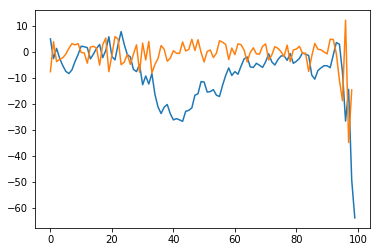

In [3]:
# transform data to be stationary
diff_values = difference(sigbufs[0][:100], 1)
plt.plot(range(sigbufs[0][:100].shape[0]), sigbufs[0][:100])
plt.plot(range(len(diff_values)), diff_values)
print(len(diff_values), sigbufs[0].shape[0])
print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

print("--- %s seconds ---" % (time.time() - start_time))

--- 3837.28752899 seconds ---


In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-30], supervised_values[-30:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
print("--- %s seconds ---" % (time.time() - start_time))

--- 3840.59761286 seconds ---


In [13]:
print(test_scaled.shape)

(30, 2)


In [15]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 300, 4)
print("--- %s seconds ---" % (time.time() - start_time))


--- 4055.31156492 seconds ---


In [16]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
print(train_scaled, train_reshaped)

(array([[ 0.15436242, -0.93288591],
       [-0.93288591,  0.71812081],
       [ 0.71812081, -0.38255034],
       [-0.38255034, -0.24832215],
       [-0.24832215, -0.16778523],
       [-0.16778523,  0.03355705],
       [ 0.03355705,  0.3557047 ],
       [ 0.3557047 ,  0.61073826],
       [ 0.61073826,  0.54362416],
       [ 0.54362416,  0.61073826],
       [ 0.61073826,  0.12751678],
       [ 0.12751678,  0.10067114],
       [ 0.10067114, -0.46308725],
       [-0.46308725,  0.42281879],
       [ 0.42281879,  0.46308725],
       [ 0.46308725,  0.36912752],
       [ 0.36912752, -0.5704698 ],
       [-0.5704698 ,  0.54362416],
       [ 0.54362416,  0.91946309],
       [ 0.91946309, -0.93288591],
       [-0.93288591, -0.03355705],
       [-0.03355705,  1.        ],
       [ 1.        ,  0.86577181],
       [ 0.86577181, -0.54362416],
       [-0.54362416, -0.40939597],
       [-0.40939597,  0.02013423],
       [ 0.02013423, -0.53020134],
       [-0.53020134,  0.03355705],
       [ 0.03355705

In [19]:
lstm_model.predict(train_reshaped, batch_size=1)
raw_values = sigbufs[0][:100]
print("--- %s seconds ---" % (time.time() - start_time))
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
print("--- %s seconds ---" % (time.time() - start_time))

--- 4187.521101 seconds ---
Month=1, Predicted=-4.839144, Expected=-3.797802
Month=2, Predicted=-2.803107, Expected=-0.703297
Month=3, Predicted=0.131985, Expected=-3.797802
Month=4, Predicted=-2.677995, Expected=-5.016850
Month=5, Predicted=-3.759050, Expected=-2.953846
Month=6, Predicted=-1.829256, Expected=-1.547253
Month=7, Predicted=-0.462673, Expected=-1.453480
Month=8, Predicted=-0.285630, Expected=-3.235165
Month=9, Predicted=-1.899422, Expected=-0.609524
Month=10, Predicted=0.562515, Expected=-4.360440
Month=11, Predicted=-2.974981, Expected=-3.610256
Month=12, Predicted=-2.280546, Expected=-2.484982
Month=13, Predicted=-1.236950, Expected=-0.328205
Month=14, Predicted=0.793800, Expected=-0.890842
Month=15, Predicted=0.338054, Expected=-1.359707
Month=16, Predicted=-0.045349, Expected=-8.861538
Month=17, Predicted=-7.358262, Expected=-10.455678
Month=18, Predicted=-8.995020, Expected=-7.173626
Month=19, Predicted=-6.152902, Expected=-6.142125
Month=20, Predicted=-5.247697, Exp

Test RMSE: 8.416


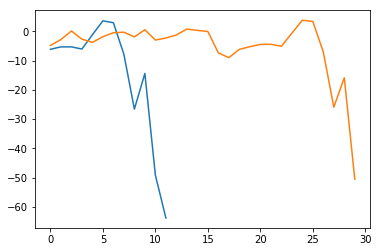

--- 4222.46997786 seconds ---


In [21]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-30:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()
print("--- %s seconds ---" % (time.time() - start_time))